In [1]:
import numpy as np 


# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [2]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM


In [3]:
# FOR REPRODUCIBILITY
np.random.seed(7)


In [4]:
# IMPORTING DATASET 
dataset = pd.read_csv('AMZN_10Y.csv', usecols=[1,2,3,4])
#dataset = dataset.reindex(index = dataset.index[::-1])


In [5]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [6]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

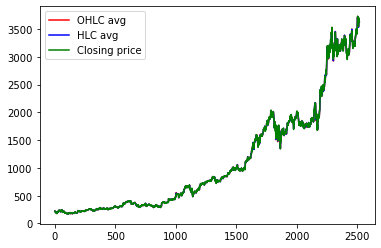

In [7]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper left')
plt.show()

In [8]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [9]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [10]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [11]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [12]:

# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))
# LSTM MODEL
#model = Sequential()
#model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(16, return_sequences = True))
#model.add(Dropout(0.2))
#model.add(LSTM(8))
#model.add(Dropout(0.1))
#model.add(Dense(1))
#model.add(Activation('linear'))

In [13]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_absolute_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=150, batch_size=10, verbose=2)

Epoch 1/150
189/189 - 38s - loss: 0.0666
Epoch 2/150
189/189 - 1s - loss: 0.0058
Epoch 3/150
189/189 - 1s - loss: 0.0030
Epoch 4/150
189/189 - 1s - loss: 0.0025
Epoch 5/150
189/189 - 1s - loss: 0.0026
Epoch 6/150
189/189 - 1s - loss: 0.0030
Epoch 7/150
189/189 - 1s - loss: 0.0024
Epoch 8/150
189/189 - 1s - loss: 0.0026
Epoch 9/150
189/189 - 1s - loss: 0.0024
Epoch 10/150
189/189 - 1s - loss: 0.0025
Epoch 11/150
189/189 - 1s - loss: 0.0025
Epoch 12/150
189/189 - 1s - loss: 0.0025
Epoch 13/150
189/189 - 1s - loss: 0.0027
Epoch 14/150
189/189 - 1s - loss: 0.0024
Epoch 15/150
189/189 - 1s - loss: 0.0026
Epoch 16/150
189/189 - 1s - loss: 0.0024
Epoch 17/150
189/189 - 1s - loss: 0.0024
Epoch 18/150
189/189 - 1s - loss: 0.0024
Epoch 19/150
189/189 - 1s - loss: 0.0026
Epoch 20/150
189/189 - 1s - loss: 0.0025
Epoch 21/150
189/189 - 1s - loss: 0.0024
Epoch 22/150
189/189 - 1s - loss: 0.0025
Epoch 23/150
189/189 - 1s - loss: 0.0026
Epoch 24/150
189/189 - 1s - loss: 0.0028
Epoch 25/150
189/189 - 1

In [14]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
# TRAINING RMSE
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 8.77


In [17]:
# TEST RMSE
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 107.68


In [18]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [19]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [20]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

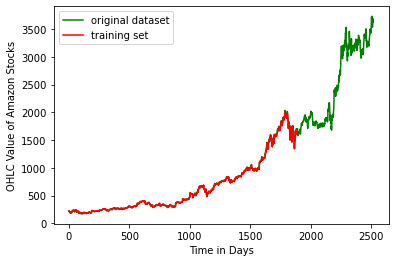

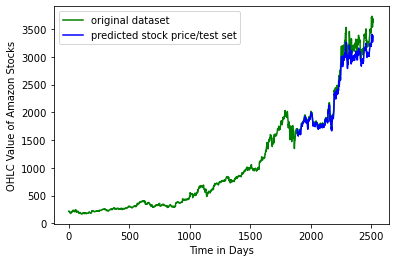

In [25]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Amazon Stocks')
plt.show()
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Amazon Stocks')
plt.show()


In [26]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val*next_val))

Last Day Value: 3372.876708984375
Next Day Value: 3066.130615234375


<ipython-input-26-ee095eb29b4a>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Last Day Value:", np.asscalar(last_val))
<ipython-input-26-ee095eb29b4a>:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  print ("Next Day Value:", np.asscalar(last_val*next_val))
